# Codes for the article

## Artificial Datasets

In [1]:
import numpy as np
import pandas as pd

## Dataset generation

In [4]:
from edgaro.data.dataset import Dataset

In [5]:
def generate_dataset(ground_truth, name, n = 1000):
    x1 = np.random.normal(0, 1, n)
    x2 = np.random.normal(0, 1, n)
    x3 = np.random.normal(0, 1, n)

    z = ground_truth(x1, x2, x3)
    p = 1 / (1 + np.exp(-z))
    y = pd.Series(np.random.binomial(1, p, n))

    X = pd.DataFrame({
        'x1': x1, 'x2': x2, 'x3': x3
    })

    return Dataset(dataframe=X, target=y, name=name)

In [6]:
ground_truth_model_group_1 = {
    'group-1-var=1': lambda x1, x2, x3: 1.5 + 2.9 * x1 - 3.7 * x2 + 1.2 * x3 + np.random.normal(0, 1, x1.shape),
    'group-1-var=2': lambda x1, x2, x3: 1.5 + 2.9 * x1 - 3.7 * x2 + 1.2 * x3 + np.random.normal(0, np.sqrt(2), x1.shape),
    'group-1-var=3': lambda x1, x2, x3: 1.5 + 2.9 * x1 - 3.7 * x2 + 1.2 * x3 + np.random.normal(0, np.sqrt(3), x1.shape)
}

ground_truth_model_group_2 = {
    'group-2-var=1': lambda x1, x2, x3: 2.5 + 2.9 * x1 - 3.7 * x2 + 1.2 * x3 + np.random.normal(0, 1, x1.shape),
    'group-2-var=2': lambda x1, x2, x3: 2.5 + 2.9 * x1 - 3.7 * x2 + 1.2 * x3 + np.random.normal(0, np.sqrt(2), x1.shape),
    'group-2-var=3': lambda x1, x2, x3: 2.5 + 2.9 * x1 - 3.7 * x2 + 1.2 * x3 + np.random.normal(0, np.sqrt(3), x1.shape)
}

ground_truth_model_group_3 = {
    'group-3-var=1': lambda x1, x2, x3: 3.5 + 2.9 * x1 - 3.7 * x2 + 1.2 * x3 + np.random.normal(0, 1, x1.shape),
    'group-3-var=2': lambda x1, x2, x3: 3.5 + 2.9 * x1 - 3.7 * x2 + 1.2 * x3 + np.random.normal(0, np.sqrt(2), x1.shape),
    'group-3-var=3': lambda x1, x2, x3: 3.5 + 2.9 * x1 - 3.7 * x2 + 1.2 * x3 + np.random.normal(0, np.sqrt(3), x1.shape)
}

ground_truth_model_group_4 = {
    'group-4-var=1': lambda x1, x2, x3: 4.5 + 2.9 * x1 - 3.7 * x2 + 1.2 * x3 + np.random.normal(0, 1, x1.shape),
    'group-4-var=2': lambda x1, x2, x3: 4.5 + 2.9 * x1 - 3.7 * x2 + 1.2 * x3 + np.random.normal(0, np.sqrt(2), x1.shape),
    'group-4-var=3': lambda x1, x2, x3: 4.5 + 2.9 * x1 - 3.7 * x2 + 1.2 * x3 + np.random.normal(0, np.sqrt(3), x1.shape)
}

### Preparations for calculations

In [ ]:
from sklearn.linear_model import LogisticRegression

from edgaro.data.dataset_array import DatasetArray
from edgaro.balancing.nested_transformer import AutomaticTransformer
from edgaro.balancing.transformer_array import TransformerArray
from edgaro.model.model import ModelFromSKLEARN, RandomForest, XGBoost
from edgaro.model.model_array import ModelArray
from edgaro.explain.explainer_array import ExplainerArray

Evals

In [ ]:
eval_dataframe = pd.DataFrame({
    'model_group': [],
    'variance': [],
    'truth_model_name': [],
    'transform_type': [],
    'method': [],
    'ml_model_type': [],
    'metric': [],
    'metric_value': [],
    'seed': []
})

In [ ]:
def extract_from_model_name(x):
    # returns model_group, variance, truth_model_name,
    # type of transformed/original, method of sampling

    split = x.split('_')
    truth_model_name = split[0]
    group = truth_model_name.split('-')[1]
    var = truth_model_name.split('=')[1]

    if len(split) == 1: return group, var, truth_model_name, 'ORIGINAL', ''

    transform_type = split[2]
    method = split[4]

    return group, var, truth_model_name, transform_type, method

def transform_eval(d, seed, ml_model):
    d1 = d.apply(
        lambda x: pd.Series(
            extract_from_model_name(x['model']),
            index=['model_group', 'variance', 'truth_model_name', 'transform_type', 'method']
        ), axis=1)
    d1['metric'] = d['metric']
    d1['metric_value'] = d['value']
    d1['seed'] = seed
    d1['ml_model_type'] = ml_model
    return d1

SDD

In [ ]:
sdd_results = pd.DataFrame({
    'sdd_X1': [], 'sdd_X2': [], 'sdd_X3': [],
    'model_group': [], 'variance': [], 'truth_model_name': [], 'transform_type': [],
    'method': [], 'ml_model_type': [], 'curve_type': [], 'seed': []
})

In [ ]:
def extract_sdd(curve, ml_model_type, curve_type, seed):
    res = pd.DataFrame({
        'sdd_X1': [], 'sdd_X2': [], 'sdd_X3': [],
        'model_group': [], 'variance': [], 'truth_model_name': [], 'transform_type': [],
        'method': []
    })

    for group in curve:
        for v in group:
            comp = pd.DataFrame(v.compare(index_base=-1))
            comp.columns = ['sdd_X1', 'sdd_X2', 'sdd_X3']
            attr = [
                extract_from_model_name(v[p].name)
                for p in range(len(v) - 1)
            ]
            comp['model_group'] = [a[0] for a in attr]
            comp['variance'] = [a[1] for a in attr]
            comp['truth_model_name'] = [a[2] for a in attr]
            comp['transform_type'] = [a[3] for a in attr]
            comp['method'] = [a[4] for a in attr]

            res = pd.concat([res, comp])

    res['ml_model_type'] = ml_model_type
    res['curve_type'] = curve_type
    res['seed'] = seed
    return res

VI

In [ ]:
vi_results = pd.DataFrame({
    'vi_X1': [], 'vi_X2': [], 'vi_X3': [], 'model_group': [], 'variance': [], 'truth_model_name': [],
    'transform_type': [], 'method': [], 'ml_model_type': [], 'seed': []
})

In [ ]:
def extract_vi(o, ml_model_type, seed):
    res = pd.DataFrame({
        'vi_X1': [], 'vi_X2': [], 'vi_X3': [],
        'model_group': [], 'variance': [], 'truth_model_name': [], 'transform_type': [],
        'method': []
    })

    for group in o:
        for v in group:
            for x in v:
                vi = pd.DataFrame(x.results, index=[0])
                vi.columns = ['vi_X1', 'vi_X2', 'vi_X3']
                attr = extract_from_model_name(x.name)
                vi['model_group'] = attr[0]
                vi['variance'] = attr[1]
                vi['truth_model_name'] = attr[2]
                vi['transform_type'] = attr[3]
                vi['method'] = attr[4]

                res = pd.concat([res, vi])

    res['ml_model_type'] = ml_model_type
    res['seed'] = seed
    return res

#### Experiment loop

In [ ]:
N = 10000

In [ ]:
explanations = {
    'rf': {'pdp': [], 'ale': [], 'vi': []},
    'lr': {'pdp': [], 'ale': [], 'vi': []},
    'xgb': {'pdp': [], 'ale': [], 'vi': []}
}

In [ ]:
for i in range(N):
    np.random.seed(i)

    # generate datasets
    df_model_group_1 = DatasetArray(
        [generate_dataset(f, name) for name, f in ground_truth_model_group_1.items()], f'group-1-seed-{i}')
    df_model_group_2 = DatasetArray(
        [generate_dataset(f, name) for name, f in ground_truth_model_group_2.items()], f'group-2-seed-{i}')
    df_model_group_3 = DatasetArray(
        [generate_dataset(f, name) for name, f in ground_truth_model_group_3.items()], f'group-3-seed-{i}')
    df_model_group_4 = DatasetArray(
        [generate_dataset(f, name) for name, f in ground_truth_model_group_4.items()], f'group-4-seed-{i}')

    # train-test split
    df_array = DatasetArray([df_model_group_1, df_model_group_2, df_model_group_3, df_model_group_4], f'datasets-seed-{i}')
    df_array.train_test_split(test_size=0.2)

    # balancing
    transformer = TransformerArray(
        AutomaticTransformer(
            keep_original_dataset=True,
            n_per_method=1
        ),
        set_suffixes=False
    )
    transformer.fit(df_array)
    df_array_transformed = transformer.transform(df_array)

    # training models and evaluating
    lr = ModelArray(ModelFromSKLEARN(LogisticRegression(n_jobs=-1)))
    lr.fit(df_array_transformed)
    lr_eval = lr.evaluate()
    lr_eval1 = transform_eval(lr_eval, i, 'logistic_regression')

    rf = ModelArray(RandomForest(n_jobs=-1))
    rf.fit(df_array_transformed)
    rf_eval = rf.evaluate()
    rf_eval1 = transform_eval(rf_eval, i, 'random_forest')

    xgb = ModelArray(XGBoost(n_jobs=-1))
    xgb.fit(df_array_transformed)
    xgb_eval = xgb.evaluate()
    xgb_eval1 = transform_eval(xgb_eval, i, 'xgb')

    eval_dataframe = pd.concat([eval_dataframe, lr_eval1, rf_eval1, xgb_eval1])

    # explanations
    # PDP
    lr_pdp_xa = ExplainerArray(lr, N=None, explanation_type='PDP')
    lr_pdp_xa.fit()
    lr_pdp = lr_pdp_xa.transform()
    lr_pdp1 = extract_sdd(lr_pdp, 'logistic_regression', 'PDP', i)
    explanations['lr']['pdp'].append(lr_pdp)

    rf_pdp_xa = ExplainerArray(rf, N=None, explanation_type='PDP')
    rf_pdp_xa.fit()
    rf_pdp = rf_pdp_xa.transform()
    rf_pdp1 = extract_sdd(rf_pdp, 'random_forest', 'PDP', i)
    explanations['rf']['pdp'].append(rf_pdp)

    xgb_pdp_xa = ExplainerArray(xgb, N=None, explanation_type='PDP')
    xgb_pdp_xa.fit()
    xgb_pdp = xgb_pdp_xa.transform()
    xgb_pdp1 = extract_sdd(xgb_pdp, 'xgb', 'PDP', i)
    explanations['xgb']['pdp'].append(xgb_pdp)

    # ALE
    lr_ale_xa = ExplainerArray(lr, N=None, explanation_type='ALE')
    lr_ale_xa.fit()
    lr_ale = lr_ale_xa.transform()
    lr_ale1 = extract_sdd(lr_ale, 'logistic_regression', 'ALE', i)
    explanations['lr']['ale'].append(lr_ale)

    rf_ale_xa = ExplainerArray(rf, N=None, explanation_type='ALE')
    rf_ale_xa.fit()
    rf_ale = rf_ale_xa.transform()
    rf_ale1 = extract_sdd(rf_ale, 'random_forest', 'ALE', i)
    explanations['rf']['ale'].append(rf_ale)

    xgb_ale_xa = ExplainerArray(xgb, N=None, explanation_type='ALE')
    xgb_ale_xa.fit()
    xgb_ale = xgb_ale_xa.transform()
    xgb_ale1 = extract_sdd(xgb_ale, 'xgb', 'ALE', i)
    explanations['xgb']['ale'].append(xgb_ale)

    # VI
    lr_vi_xa = ExplainerArray(lr, N=None, explanation_type='VI')
    lr_vi_xa.fit()
    lr_vi = lr_vi_xa.transform()
    lr_vi1 = extract_vi(lr_vi, 'logistic_regression', i)
    explanations['lr']['vi'].append(lr_vi)

    rf_vi_xa = ExplainerArray(rf, N=None, explanation_type='VI')
    rf_vi_xa.fit()
    rf_vi = rf_vi_xa.transform()
    rf_vi1 = extract_vi(rf_vi, 'random_forest', i)
    explanations['rf']['vi'].append(rf_vi)

    xgb_vi_xa = ExplainerArray(xgb, N=None, explanation_type='VI')
    xgb_vi_xa.fit()
    xgb_vi = xgb_vi_xa.transform()
    xgb_vi1 = extract_vi(xgb_vi, 'xgb', i)
    explanations['xgb']['vi'].append(xgb_vi)

    sdd_results = pd.concat([sdd_results, lr_pdp1, rf_pdp1, xgb_pdp1, lr_ale1, rf_ale1, xgb_ale1])
    vi_results = pd.concat([vi_results, lr_vi1, rf_vi1, xgb_vi1])

#### Visualisations

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sns.set_style("whitegrid")
plt.style.use('tableau-colorblind10')

In [5]:
def transform_name(x):
    if x == 'Borderline (OVERSAMPLING)':
        return 'Borderline SMOTE (OVERSAMPLING)'

    if x == 'Near (UNDERSAMPLING)':
        return 'Near Miss (UNDERSAMPLING)'

    if x == 'SMOTE (COMBINED)':
        return 'SMOTETomek (COMBINED)'

    return x

In [6]:
sdd_results['method'] = sdd_results.method + ' (' + sdd_results.transform_type + ')'
sdd_results.method = sdd_results.method.apply(transform_name)

In [7]:
sdd_results.ml_model_type = sdd_results.ml_model_type.apply(lambda x: {
    'random_forest': 'Random Forest',
    'logistic_regression': 'Logistic Regression',
    'xgb': 'XGBoost'
}[x])

In [8]:
model_names = np.unique(sdd_results.truth_model_name).tolist()
pdp = sdd_results[sdd_results.curve_type == 'PDP'][['sdd_X1', 'sdd_X2', 'sdd_X3', 'method', 'truth_model_name', 'ml_model_type']]
pdp = pd.melt(pdp, id_vars=['method', 'truth_model_name', 'ml_model_type'], value_vars=['sdd_X1', 'sdd_X2', 'sdd_X3'])

In [9]:
ml_model_type_order = ['Random Forest', 'Logistic Regression', 'XGBoost']

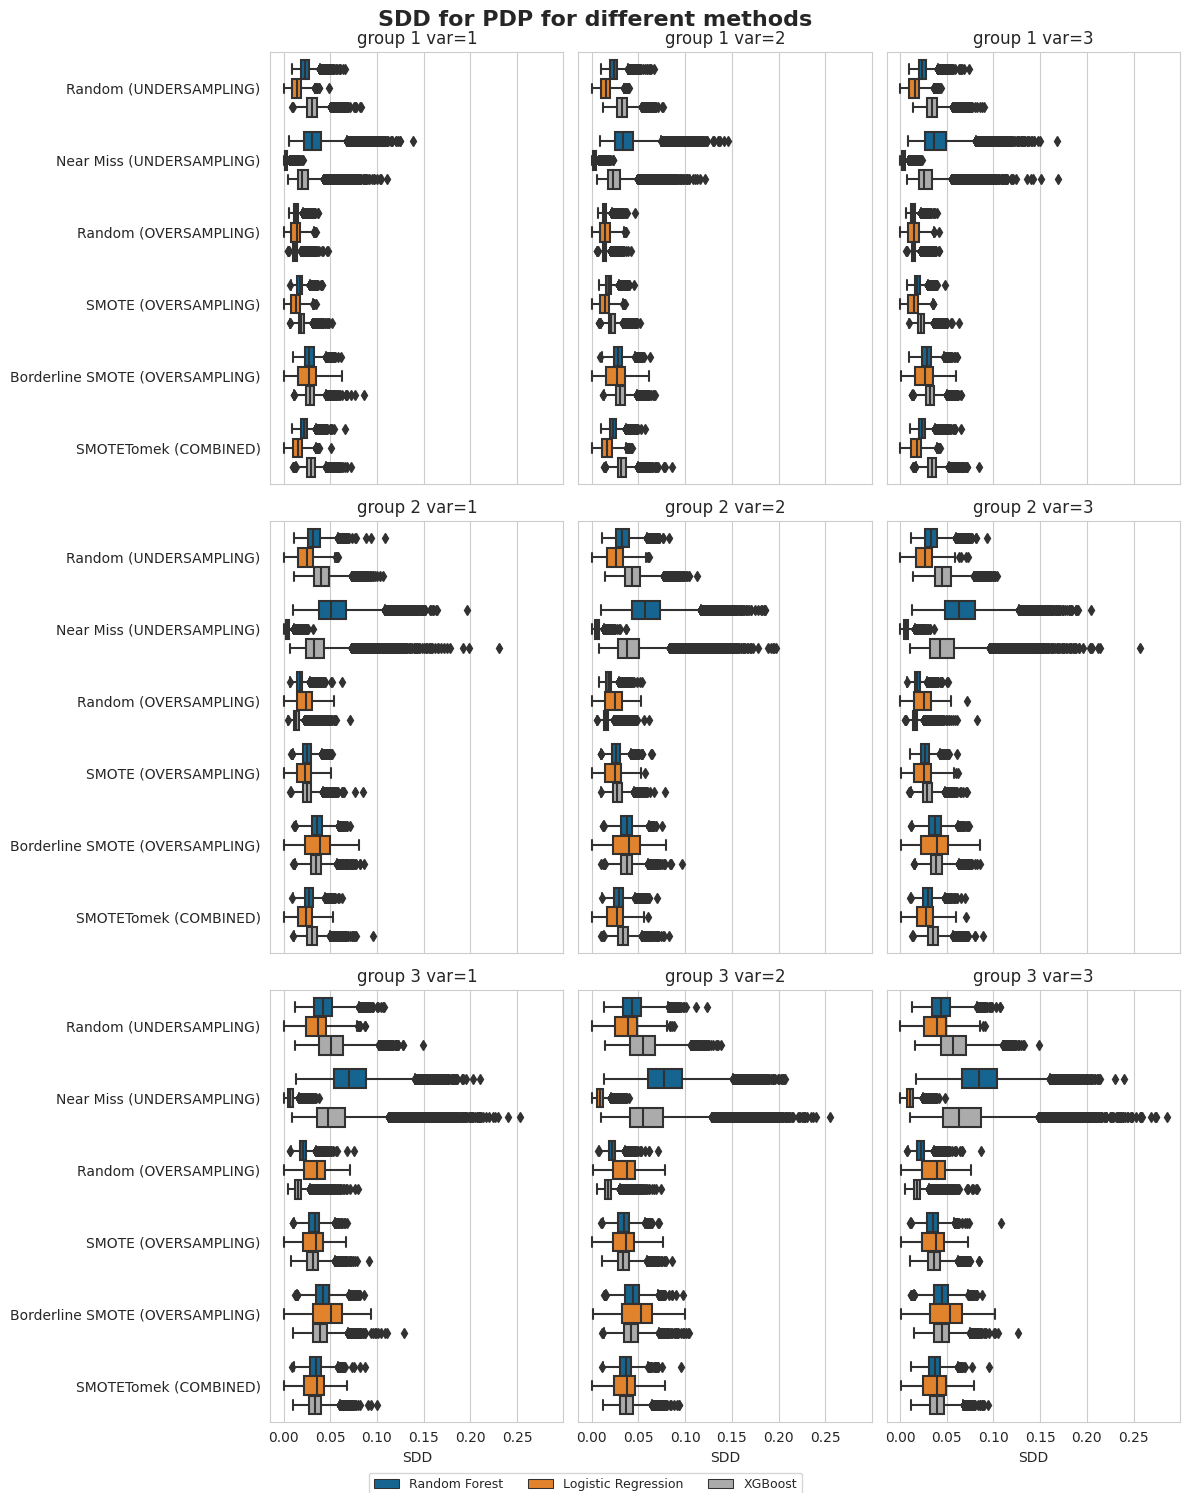

In [10]:
fig, ax = plt.subplots(3, 3, sharex='all', sharey='all', figsize = (12, 15))

tit = plt.suptitle('SDD for PDP for different methods', fontsize=16, weight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.92)

for i in range(3):
    for j in range(3):
        plt.sca(ax[i][j])
        sns.boxplot(x='value', y='method', hue='ml_model_type', hue_order=ml_model_type_order, data=pdp[pdp.truth_model_name == model_names[i*3 + j]])
        plt.title(model_names[3 * i + j].replace('-', ' '))
        plt.legend().set_visible(False)
        if i == 2:
            plt.xlabel('SDD')
        else:
            plt.xlabel('')

        plt.ylabel('')

handles, labels = ax[-1][-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc = (0.31, -0.002), ncol=3, fontsize=9)
fig.subplots_adjust(bottom=0.02)

plt.tight_layout()
plt.savefig('lr_ground_truth_pdp.pdf', bbox_extra_artists=(lgd,tit), bbox_inches='tight')
plt.show()

In [11]:
model_names = np.unique(sdd_results.truth_model_name).tolist()
pdp = sdd_results[sdd_results.curve_type == 'ALE'][['sdd_X1', 'sdd_X2', 'sdd_X3', 'method', 'truth_model_name', 'ml_model_type']]
sdd_results.method = sdd_results.method.apply(transform_name)
pdp = pd.melt(pdp, id_vars=['method', 'truth_model_name', 'ml_model_type'], value_vars=['sdd_X1', 'sdd_X2', 'sdd_X3'])

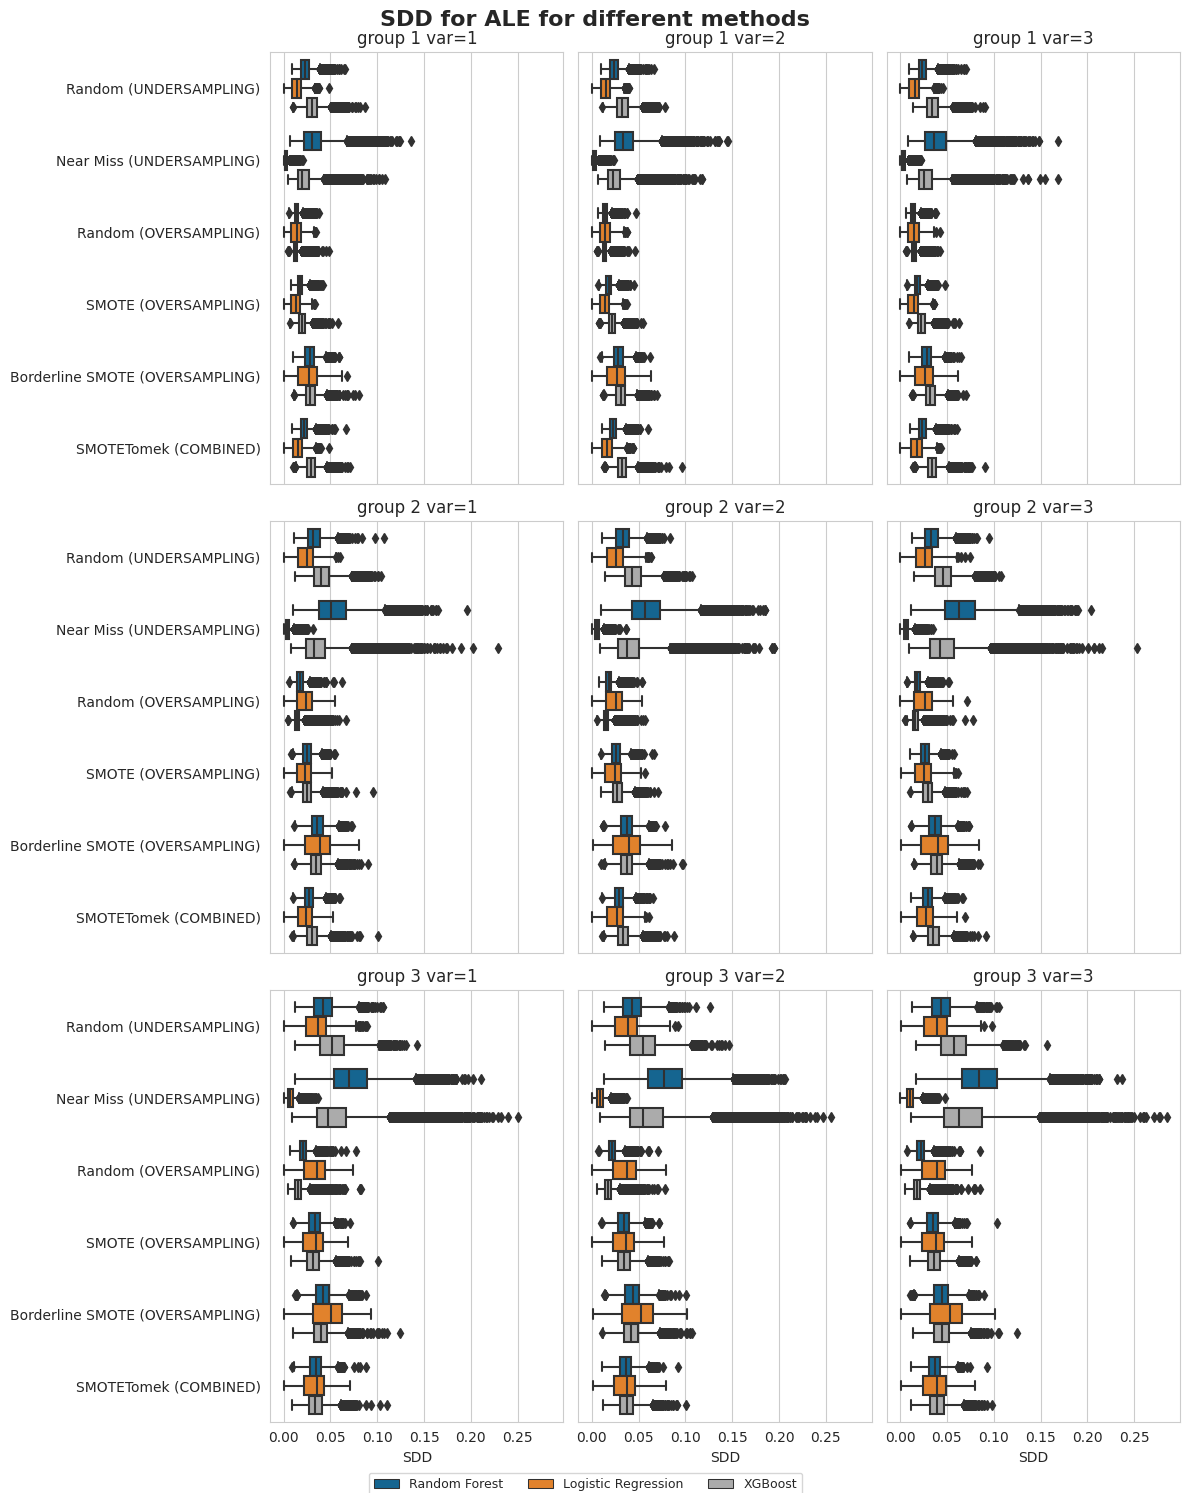

In [12]:
fig, ax = plt.subplots(3, 3, sharex='all', sharey='all', figsize = (12, 15))

tit = plt.suptitle('SDD for ALE for different methods', fontsize=16, weight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.92)

for i in range(3):
    for j in range(3):
        plt.sca(ax[i][j])
        sns.boxplot(x='value', y='method', hue='ml_model_type', hue_order=ml_model_type_order, data=pdp[pdp.truth_model_name == model_names[i*3 + j]])
        plt.title(model_names[3 * i + j].replace('-', ' '))
        plt.legend().set_visible(False)
        if i == 2:
            plt.xlabel('SDD')
        else:
            plt.xlabel('')

        plt.ylabel('')

handles, labels = ax[-1][-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc = (0.31, -0.002), ncol=3, fontsize=9)
fig.subplots_adjust(bottom=0.02)

plt.tight_layout()
plt.savefig('lr_ground_truth_ale.pdf', bbox_extra_artists=(lgd,tit), bbox_inches='tight')
plt.show()

In [13]:
eval_dataframe = pd.read_csv('evals.csv')

In [14]:
eval_dataframe = eval_dataframe[eval_dataframe.metric == 'balanced_accuracy_score']
eval_dataframe['method'] = eval_dataframe.method + ' (' + eval_dataframe.transform_type + ')'

In [15]:
def transform_name2(x):
    if x == 'Borderline (OVERSAMPLING)':
        return 'Borderline SMOTE (OVERSAMPLING)'

    if x == 'Near (UNDERSAMPLING)':
        return 'Near Miss (UNDERSAMPLING)'

    if x == 'SMOTE (COMBINED)':
        return 'SMOTETomek (COMBINED)'

    if pd.isnull(x):
        return 'ORIGINAL'

    return x

In [16]:
eval_dataframe.method = eval_dataframe.method.apply(transform_name2)

In [17]:
eval_dataframe.ml_model_type = eval_dataframe.ml_model_type.apply(lambda x: {
    'random_forest': 'Random Forest',
    'logistic_regression': 'Logistic Regression',
    'xgb': 'XGBoost'
}[x])

In [18]:
model_names = np.unique(eval_dataframe.truth_model_name).tolist()

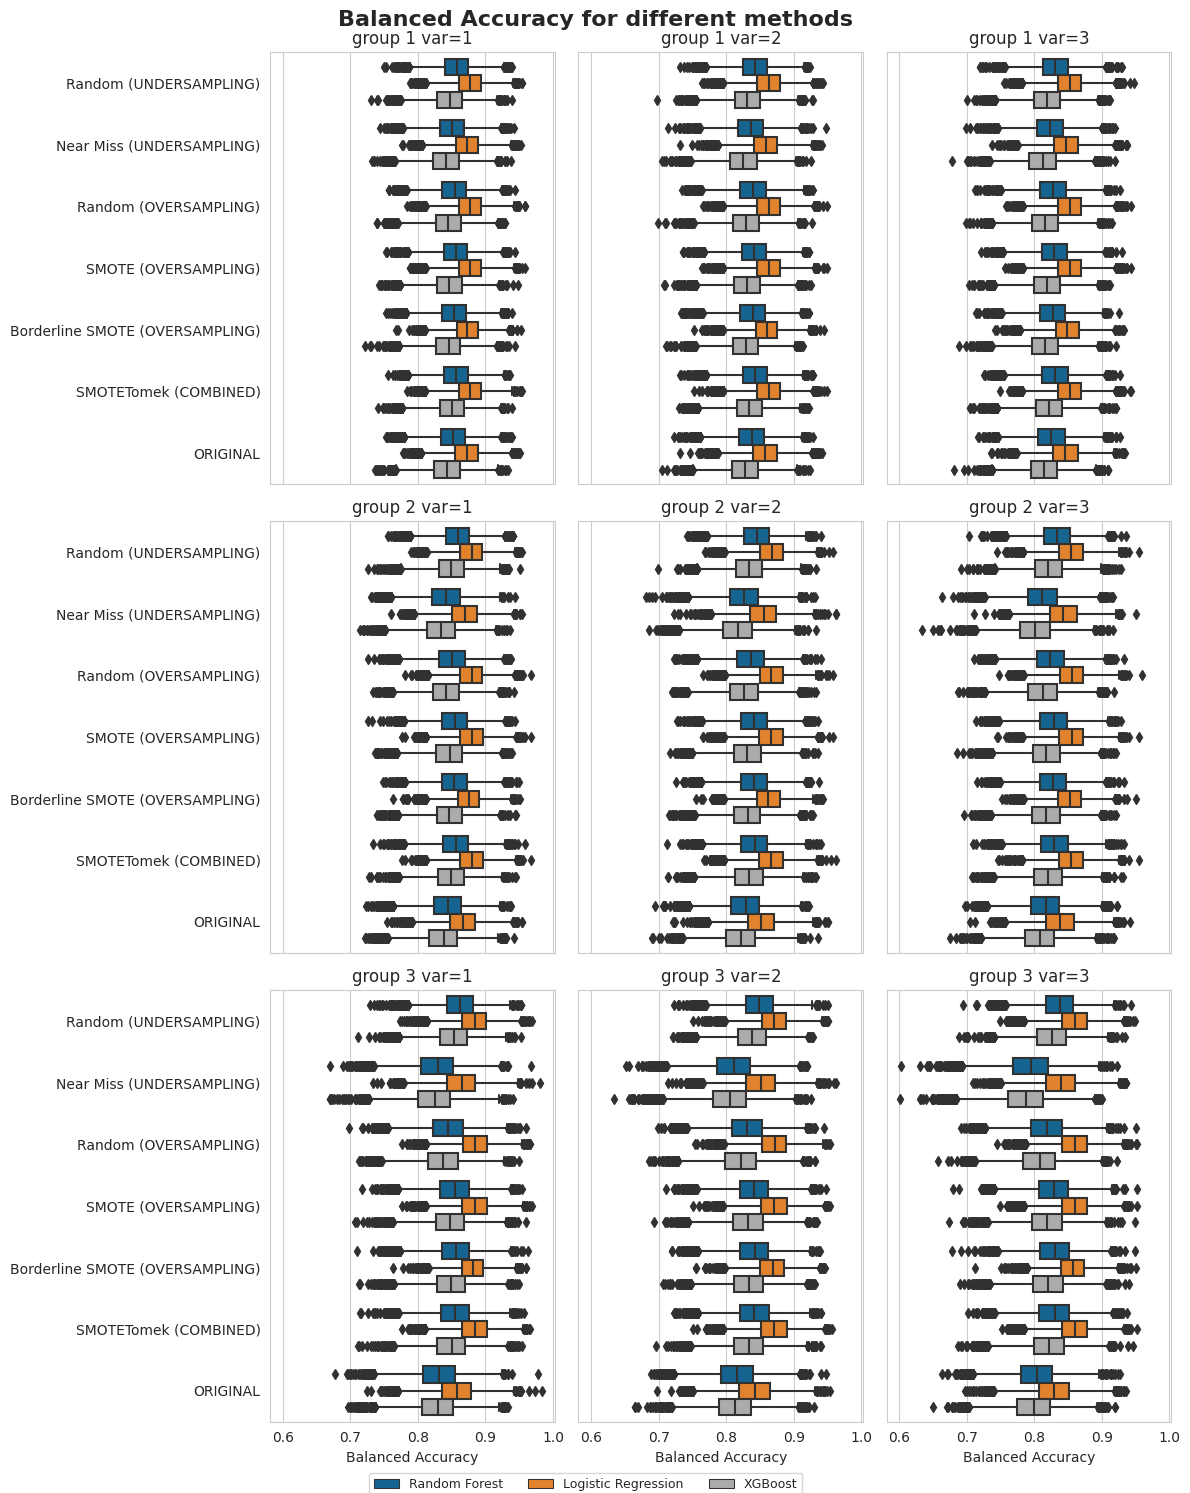

In [19]:
fig, ax = plt.subplots(3, 3, sharex='all', sharey='all', figsize = (12, 15))

tit = plt.suptitle('Balanced Accuracy for different methods', fontsize=16, weight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.92)

for i in range(3):
    for j in range(3):
        plt.sca(ax[i][j])
        sns.boxplot(x='metric_value', y='method', hue='ml_model_type', hue_order=ml_model_type_order, data=eval_dataframe[eval_dataframe.truth_model_name == model_names[i*3 + j]])
        plt.title(model_names[3 * i + j].replace('-', ' '))
        plt.legend().set_visible(False)

        if i == 2:
            plt.xlabel('Balanced Accuracy')
        else:
            plt.xlabel('')

        plt.ylabel('')

handles, labels = ax[-1][-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc = (0.31, -0.002), ncol=3, fontsize=9)
fig.subplots_adjust(bottom=0.02)

plt.tight_layout()
plt.savefig('lr_ground_truth_balanced_accuracy.pdf', bbox_extra_artists=(lgd,tit), bbox_inches='tight')
plt.show()

#### Performance gain

In [4]:
methods = [
    'UNDERSAMPLING__Random',
    'UNDERSAMPLING__Near_Miss',
    'OVERSAMPLING__Random',
    'OVERSAMPLING__SMOTE',
    'OVERSAMPLING__Borderline_SMOTE',
    'COMBINED__SMOTE_Tomek'
]

names = [
    'Random Undersampling',
    'Near Miss (undersampling)',
    'Random Oversampling',
    'SMOTE (oversampling)',
    'Borderline SMOTE (oversampling)',
    'SMOTETomek (hybrid)'
]

In [ ]:
ale_rf = explanations['rf']['ale']
ale_xgb = explanations['xgb']['ale']
ale_le = explanations['lr']['ale']

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey='all', sharex='all')

plt.sca(ax[0])
ale_rf.plot_performance_gain_analysis(ax=ax[0], model_filters=methods, filter_labels=names)
plt.title('Performance gain analysis with ALE\non Random Forest models on artificial datasets')
plt.xlabel('Performance gain (balanced accuracy)')
plt.legend().set_visible(False)

plt.sca(ax[1])
ale_xgb.plot_performance_gain_analysis(ax=ax[1], model_filters=methods, filter_labels=names)
plt.title('Performance gain analysis with ALE\non XGBoost models on artificial datasets')
plt.xlabel('Performance gain (balanced accuracy)')
plt.ylabel('')
plt.legend().set_visible(False)

plt.sca(ax[2])
ale_lr.plot_performance_gain_analysis(ax=ax[2], model_filters=methods, filter_labels=names)
plt.title('Performance gain analysis with ALE\non Logistic Regression models on artificial datasets')
plt.xlabel('Performance gain (balanced accuracy)')
plt.ylabel('')
plt.legend().set_visible(False)

tit = plt.suptitle('Performance gain analysis with for different balancing methods', y=0.98, fontsize=16, weight='bold')

handles, labels = ax[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, ncol=3, fontsize=9, bbox_to_anchor=(0.71, 0))

plt.tight_layout()
plt.savefig('performance_gain_methods_artificial.pdf', bbox_extra_artists=(lgd,tit), bbox_inches='tight')
plt.show()